### 실습목표

Augmentation을 모델 학습에 적용하기

Augmentation의 적용을 통한 학습 효과 확인하기

최신 data augmentation 기법 구현 및 활용하기

### 학습 내용

Augmentation 적용 (1) 데이터 불러오기

Augmentation 적용 (2) Augmentation 적용하기

Augmentation 적용 (3) 비교 실험하기

심화 기법 (1) Cutmix Augmentation

심화 기법 (2) Mixup Augmentation

In [1]:
#학습할 디렉터리 만들기
! mkdir -p ~/aiffel/data_augmentation/data

## Augmentation 적용

### 데이터 불러오기

Augmentation을 Tensorflow모델에 어떻게 적용할 수 있는지(*이미지 데이터 전처리 방법과 활용방법)에 대해 알아볼 겁니다.

필요한 라이브러리 불러오기

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


학습 전에 GPU환경은 필수!!!로 확인해야합니다.

#### 데이터셋 불러오기

Standford_dogs dataset

- class: 120견종 이미지

- Training image : 12000

- Test image: 8580

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


데이터 확인

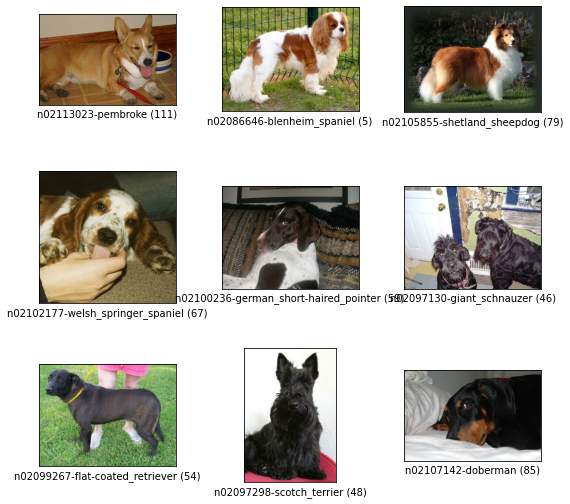

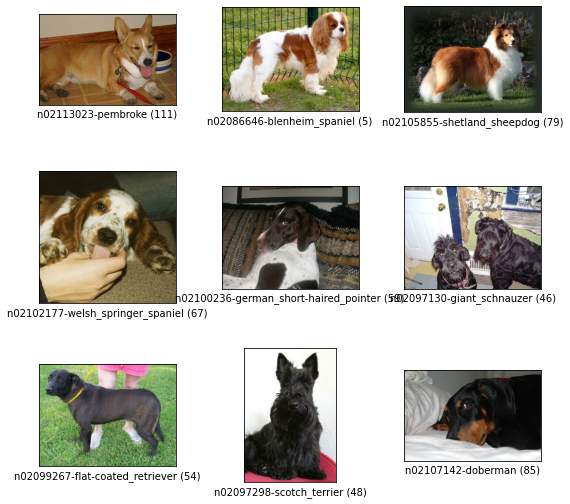

In [4]:
tfds.show_examples(ds_train, ds_info)

### Augmentation 적용하기

#### Tensorflow Random Augmentation API사용

이미지 데이터셋에 대해 랜덤한 확률로 적용할 수 있는 augmentation함수들을 알려드립니다.

random_brightness()

random_contrast()

random_crop()

random_flip_left_right()

random_flip_up_down()

random_hue()

random_jpeg_quality()

random_saturation()

#### 전처리 함수

이미지의 변환의 결과로 리턴 받은 이미지를 다음 함수의 입력으로 들어가기 때문에 재사용이 되는 구조가 되어 효율적입니다.(*아래의 함수 구조)

아래의 함수에 대한 설명을 하자면,

입력 이미지 :  0~1(float32, normalize)

resize:(224,224)로 구성이 되어 있습니다.


이 함수는 훈련용과 테스트용으로 사용되는 모든 이미지에 적용됩니다.



In [ ]:
def 전처리_함수(image, label):   # 변환할 이미지와 라벨
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


위의 함수와 random augmentation함수들을 사용하겠습니다.

random_flip_left_right와 random_brightness()활용합니다.

좌우 대칭을 통해서 이미지 데이터를 들리고 밝기 조절을 이용하여 다양한 환경에 있는 이미지에 대응할 강한 함수를 만들어 보러 가죠


In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


이제, 메인 함수 apply_normalize_on_dataset를 만들어보겠습니다.

이 함수에는 원본 데이터셋에 augmentation을 적용해서 가공한 형태의 새로운 데이터셋을 얻게되는 과정을 구현한 것입니다.

전처리 과정(normalize, resize, augmentation, shuffle)수행을 하지만 shuffle, augmentation은 테스트에는 적용을 하지 않을 겁니다.


In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


다양한 augment()함수 구현하기

In [8]:
# make random augment function

def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

### 비교실험 하기

Augmentation적용한 데이터를 학습한 모델과 그렇지 않은 채로 데이터로 학습된 모델의 성능을 비교합니다.



아래의 코드는 ResNet50(Tensorflow keras) 중 imagenet로 훈련된 모델입니다.

include_top는 마지막에 fc layer을 포함할지 여부입니다. 왜냐하면, 해당 레이어를 포함하지 않고 생성하면 특성 추출기만 불러와서 수정된 fc layer를 붙여서 활용할 수 있게 됩니다.

이로 인해 ImageNet와 test set은 다른 클래스를 가지게 되고, fc layer의 구조 또한 다르게 됩니다.

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


Augmentation을 적용한 데이터셋으로 학습시킬 ResNet

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


apply_normalize_on_dataset() + with_aug=False

apply_normalize_on_dataset() + with_aug=True

로 구분하여 augmentation이 적용된 부분과 아닌부분이 나오도록 합니다

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.

Epoch =20을 해야 충분히 학습이 되지만 시간이 너무 오래 걸려서 여기선 Epoch =3으로 하겠습니다.


In [12]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
750/750 [==============================] - 353s 432ms/step - loss: 3.2475 - accuracy: 0.2720 - val_loss: 3.5871 - val_accuracy: 0.1868
Epoch 2/3
750/750 [==============================] - 323s 431ms/step - loss: 0.9442 - accuracy: 0.7303 - val_loss: 1.2178 - val_accuracy: 0.6475
Epoch 3/3
750/750 [==============================] - 324s 432ms/step - loss: 0.3112 - accuracy: 0.9321 - val_loss: 0.9740 - val_accuracy: 0.7153
Epoch 1/3
750/750 [==============================] - 332s 432ms/step - loss: 3.2058 - accuracy: 0.2746 - val_loss: 3.2307 - val_accuracy: 0.2243
Epoch 2/3
750/750 [==============================] - 325s 433ms/step - loss: 1.0701 - accuracy: 0.7017 - val_loss: 1.1886 - val_accuracy: 0.6582
Epoch 3/3
750/750 [==============================] - 324s 432ms/step - loss: 0.5916 - accuracy: 0.8296 - val_loss: 1.5331 - val_accuracy: 0.5863


훈련 과정 시각화입니다.

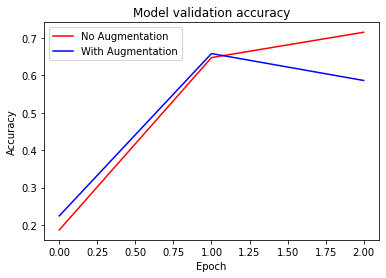

In [13]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

확대본 입니다.

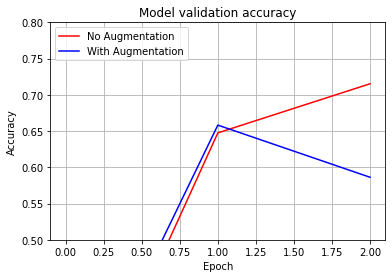

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### Cutmix Augmentation

네이버 클로바에서 발표한 CutMix는 말 그대로 이미지를 자르고 섞는 것입니다.

Mixup은 특정 비율로 픽셀별 값을 섞기이고, Cutout는 이미지를 잘라내는 방식입니다. 고로, CutMix는 일정 영역을 잘라서 붙여주는 방법입니다.


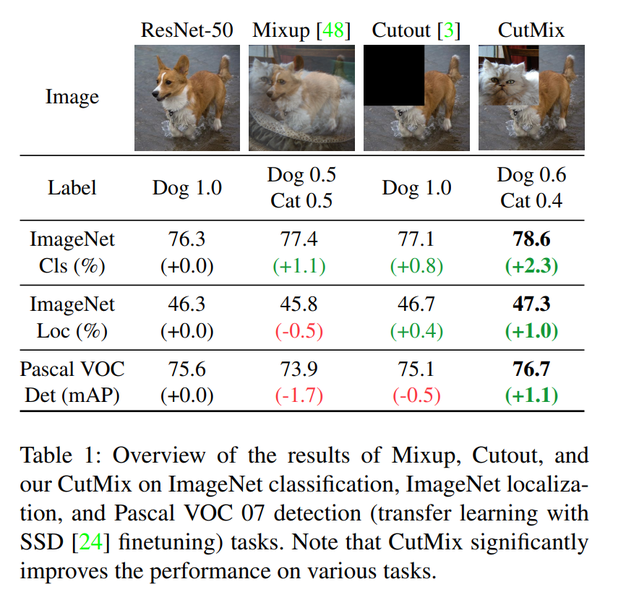


#### 이미지 섞기

배치 내의 이미지 두 개를 골라서 섞어줍니다.

*바운딩박스: 이미지에서 잘라서 섞어주는 영역입니다.*



아래의 함수는 바운딩 박스의 위치를 랜덤하게 설정하고 이 부분을 잘라내서 두 개의 이미지로 섞어주는 것입니다.

우리는 텐서플로우 연산을 통해서 이미지를 텐서로 만드럭고 이미지는 tfds에서 한 장 뽑아서 사용할 겁니다.


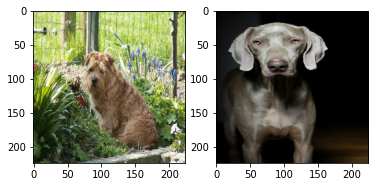

In [15]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

왼쪽의 이미지는 바탕 이미지이고 오른쪽에 있는 이미지는 삽입할 이미지일때, 바탕이미지에 삽입할 위치를 결정하는 함수를 구현할 겁니다.

이미지는 (224,224)로 resize할 거지만 width, height는 달라도 가변적 적용이 가능하기에 임의의 이미지가 들어와도 구현이 잘되는 함수를 구현하겠습니다.

In [16]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(58, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(112, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


바탕이미지의 바운딩 박스 바깥쪽 영역에 삽입이미지를 넣어 합치는 함수를 구현합니다.

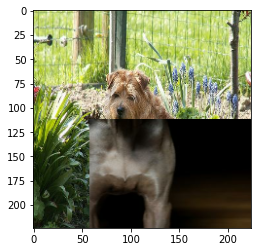

In [17]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 라벨 섞기

이미지를 섞으면 당연히 라벨 또한 적절한 비율로 섞어야 합니다.

CutMix에서는 면적에 비례해서 라벨을 섞고 섞인 이미지는 전체 이미지 대비 비율을 계산해서 두 가지의 라벨 비율을 더합니다.

라벨 벡터는 원핫 인코딩이 아니라 클래스  영역을 배분하는 형식입니다.



In [18]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3705357 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.62946427,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

두 함수 mix_2_images()와 mix_2_label()활용하여 배치단위 cutmix()함수 구현

In [19]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### Mixup Augmentation

두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단합니다.

왜냐하면, 두 이미지를 섞을 비율은 일정 범위에서 섞고 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 되기 때문입니다..

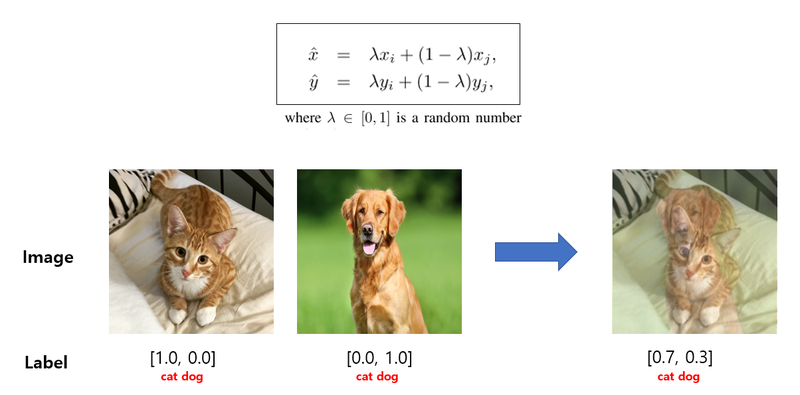

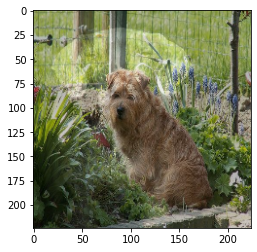

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.27678454 0.         0.
 0.         0.         0.         0.         0.72321546 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [20]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

위의 함수를 활용하여 배치 단위의 mixup() 함수를 구현

In [21]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3
